<a href="https://colab.research.google.com/github/bajibaji01/polypeptide_z/blob/main/gai/gai_af_cyc_design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#af_cyc_design

**Cyclic peptide structure prediction and design using AlphaFold**

Stephen Rettie, Katelyn Campbell, Asim Bera, Alex Kang, Simon Kozlov, Joshmyn De La Cruz, Victor Adebomi, Guangfeng Zhou, Frank DiMaio, Sergey Ovchinnikov, Gaurav Bhardwaj

doi: https://doi.org/10.1101/2023.02.25.529956


In [1]:
#@title setup (~2 minutes) 先运行这个
%%time
import os
if not os.path.isdir("params"):
  # get code
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git@v1.1.1")
  # for debugging
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")
  # download params
  os.system("mkdir params")
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar")
  os.system("tar -xf alphafold_params_2022-12-06.tar -C params")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
from colabdesign import mk_afdesign_model, clear_mem
from IPython.display import HTML
from google.colab import files
import numpy as np

import jax
import jax.numpy as jnp
from colabdesign.af.alphafold.common import residue_constants

def get_pdb(pdb_code=""):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    os.system(f"wget -qnc https://files.rcsb.org/view/{pdb_code}.pdb")
    return f"{pdb_code}.pdb"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def add_cyclic_offset(self, offset_type=2):
  '''add cyclic offset to connect N and C term'''
  def cyclic_offset(L):
    i = np.arange(L)
    ij = np.stack([i,i+L],-1)
    offset = i[:,None] - i[None,:]
    c_offset = np.abs(ij[:,None,:,None] - ij[None,:,None,:]).min((2,3))
    if offset_type == 1:
      c_offset = c_offset
    elif offset_type >= 2:
      a = c_offset < np.abs(offset)
      c_offset[a] = -c_offset[a]
    if offset_type == 3:
      idx = np.abs(c_offset) > 2
      c_offset[idx] = (32 * c_offset[idx] )/  abs(c_offset[idx])
    return c_offset * np.sign(offset)
  idx = self._inputs["residue_index"]
  offset = np.array(idx[:,None] - idx[None,:])

  if self.protocol == "binder":
    c_offset = cyclic_offset(self._binder_len)
    offset[self._target_len:,self._target_len:] = c_offset

  if self.protocol in ["fixbb","partial","hallucination"]:
    Ln = 0
    for L in self._lengths:
      offset[Ln:Ln+L,Ln:Ln+L] = cyclic_offset(L)
      Ln += L
  self._inputs["offset"] = offset

def add_rg_loss(self, weight=0.1):
  '''add radius of gyration loss'''
  def loss_fn(inputs, outputs):
    xyz = outputs["structure_module"]
    ca = xyz["final_atom_positions"][:,residue_constants.atom_order["CA"]]
    rg = jnp.sqrt(jnp.square(ca - ca.mean(0)).sum(-1).mean() + 1e-8)
    rg_th = 2.38 * ca.shape[0] ** 0.365
    rg = jax.nn.elu(rg - rg_th)
    return {"rg":rg}
  self._callbacks["model"]["loss"].append(loss_fn)
  self.opt["weights"]["rg"] = weight

CPU times: user 1.58 s, sys: 251 ms, total: 1.83 s
Wall time: 1min 56s


# fixed backbone design (fixbb) (~2 minutes)
For a given protein backbone, generate/design a new sequence that AlphaFold thinks folds into that conformation.

In [10]:
clear_mem()
af_model = mk_afdesign_model(protocol="fixbb")
af_model.prep_inputs(pdb_filename=get_pdb("7m28"), chain="A")
add_cyclic_offset(af_model, offset_type=2)

print("length",  af_model._len)
print("weights", af_model.opt["weights"])

length 7
weights {'con': 0.0, 'dgram_cce': 1.0, 'exp_res': 0.0, 'fape': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'rmsd': 0.0, 'seq_ent': 0.0}


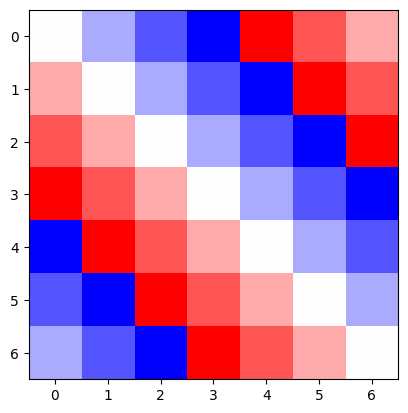

In [11]:
import matplotlib.pyplot as plt
plt.imshow(af_model._inputs["offset"],cmap="bwr")

In [12]:
af_model.restart()
af_model.design_3stage()

Stage 1: running (logits → soft)


AssertionError: ERROR: no model params defined

In [ ]:
af_model.plot_traj()

In [ ]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb(show_mainchains=True)

In [ ]:
HTML(af_model.animate())

In [ ]:
af_model.get_seqs()

# hallucination (~1 minute)
For a given length, generate/hallucinate a protein sequence that AlphaFold thinks folds into a well structured protein (high plddt, low pae, many contacts).

In [13]:
clear_mem()
af_model = mk_afdesign_model(protocol="hallucination")
af_model.prep_inputs(length=13, rm_aa="C")
add_cyclic_offset(af_model)
# add_rg_loss(af_model)

print("length",af_model._len)
print("weights",af_model.opt["weights"])

length 13
weights {'con': 1.0, 'exp_res': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'seq_ent': 0.0}


In [14]:
# pre-design with gumbel initialization and softmax activation
af_model.restart()
af_model.set_seq(mode="gumbel")
af_model.set_opt("con", binary=True, cutoff=21.6875, num=af_model._len, seqsep=0)
af_model.set_weights(pae=1, plddt=1, con=0.5)
af_model.design_soft(50)

# three stage design
af_model.set_seq(seq=af_model.aux["seq"]["pseudo"])
af_model.design_3stage(50,50,10)

AssertionError: ERROR: no model params defined

In [ ]:
af_model.save_pdb(f"{af_model.protocol}.pdb")
af_model.plot_pdb(show_mainchains=True)

In [ ]:
HTML(af_model.animate())

In [ ]:
af_model.get_seqs()

# 批量生产环肽骨架

In [2]:
clear_mem()
os.makedirs("./cyc_database/cyc_database_18aa/", exist_ok=True)
af_model = mk_afdesign_model(protocol="hallucination")
# 设置环肽长度，排除半胱氨酸 C
af_model.prep_inputs(length=18, rm_aa="C")
# 排除半胱氨酸
add_cyclic_offset(af_model)
print("length", af_model._len)
print("weights", af_model.opt["weights"])
# 生成10000个骨架
for i in range(0,100):
  af_model.restart()
  af_model.set_seq(mode="gumbel")
  af_model.set_opt("con", binary=True, cutoff=21.6875, num=af_model._len, seqsep=0)
  af_model.set_weights(pae=1, plddt=1, con=0.5)
  af_model.design_soft(50)
  # three-stage fine tuning
  af_model.set_seq(seq=af_model.aux["seq"]["pseudo"])
  af_model.design_3stage(50,50,10)
  af_model.save_pdb(f"./cyc_database/cyc_database_18aa/{str(i)}.pdb")


length 18
weights {'con': 1.0, 'exp_res': 0.0, 'helix': 0.0, 'pae': 0.0, 'plddt': 0.0, 'seq_ent': 0.0}
1 models [1] recycles 0 hard 0 soft 1 temp 1 loss 0.79 pae 0.27 con 0.04 plddt 0.50 ptm 0.02
2 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.68 pae 0.28 con 0.02 plddt 0.62 ptm 0.02
3 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.65 pae 0.28 con 0.03 plddt 0.65 ptm 0.02
4 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.69 pae 0.28 con 0.02 plddt 0.60 ptm 0.02
5 models [0] recycles 0 hard 0 soft 1 temp 1 loss 0.68 pae 0.26 con 0.02 plddt 0.59 ptm 0.02
6 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.65 pae 0.28 con 0.04 plddt 0.64 ptm 0.02
7 models [2] recycles 0 hard 0 soft 1 temp 1 loss 0.68 pae 0.28 con 0.03 plddt 0.61 ptm 0.02
8 models [3] recycles 0 hard 0 soft 1 temp 1 loss 0.66 pae 0.31 con 0.03 plddt 0.66 ptm 0.02
9 models [2] recycles 0 hard 0 soft 1 temp 1 loss 0.28 pae 0.11 con 0.14 plddt 0.89 ptm 0.03
10 models [1] recycles 0 hard 0 soft 1 temp 1 loss 0.61 pae 

KeyboardInterrupt: 

In [ ]:
# 生成的 PDB 文件批量转成 silent 格式
silentfrompdbsparallel ./*.pdb > cyc_peptide.silent

# MotifGraft：motif 嵌段嫁接到环肽   需要使用Rosetta
Scaffold我们将 p53 的 motif（FSDLW）嫁接到上一步生成的环肽骨架。
MotifGraft 的输入包含三部分：
Motif
想嫁接的片段（这里是 FSDLW）。
Context
与 motif 相互作用的目标蛋白（MDM2）。
Pose(s)
想 graft motif 上去的骨架（环肽 scaffold）。
MotifGraft 的任务：在环肽骨架里，找到与 motif 兼容的片段，并用 motif 替换

In [ ]:
# 以下是精简后的 MotifGraft XML 配置（可根据需求进一步优化参数）：
<ROSETTASCRIPTS>
    <MOVERS>
      <MotifGraft name="motif_grafting"
        context_structure="MDM2.pdb"
        motif_structure="motif.pdb"
            RMSD_tolerance="4"
            NC_points_RMSD_tolerance="4"
            hotspots="1:5"
            clash_score_cutoff="10"
            full_motif_bb_alignment="1"
            graft_only_hotspots_by_replacement="1"
            revert_graft_to_native_sequence="1" />
    </MOVERS>
    <PROTOCOLS>
      <Add mover_name="motif_grafting" />
    </PROTOCOLS>
</ROSETTASCRIPTS>

In [ ]:
# 运行 MotifGraft：
/path/to/rosetta_scripts.mpi.linuxgccrelease \
    -in:file:silent=cyc_peptide.silent \
    -in:file:silent_read_through_errors \
    -out:file:silent=out.silent \
    -out:file:silent_struct_type=binary \
    -parser:protocol=paper_motif_graft.xml \
    -corrections:beta_nov16

#  ProteinMPNN + FastRelax：环肽序列优化  本地？

In [ ]:
# https://github.com/nrbennet/dl_binder_design 参考
# 若希望保留 F、W 等关键位点，可先添加固定标记：
python helper_scripts/addFIXEDlabels.py
# 如果要全部重新设计序列：
mpnn_fr/dl_interface_design.py -silent out.silent

# AlphaFold 验证最终模型  ipynb？
评估模型折叠稳定性与界面质量

In [ ]:
pdb = 'diffused_binder_cyclic_1_mpnn1'
model = mk_afdesign_model('binder')
model.prep_inputs(
  f'{pdb}.pdb',
  binder_chain='B',
  target_chain='A',
  use_binder_template=False,
  use_multimer=True,
  use_initial_guess=True)
add_cyclic_offset(model,offset_type=2)
model.set_seq(mode='wildtype')
model.set_opt(num_recycles=1)
model.predict(models=[0,1], verbose=False)
model.save_pdb(f'{pdb}_prediction.pdb')
rmsd = model.aux['losses']['rmsd']
ipae = model.aux['all']['losses']['i_pae'][0]
with open('score.sc','a') as outfile:
  outfile.write(f'{pdb},{ipae},{rmsd}\n')
# 常用过滤标准：
# 界面预测对齐误差（iPAE） < 0.15
# RMSD < 1.5 Å